## PROPHET

In [119]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import pickle
import os

#### Declare some visual functions

In [120]:
def plot_actual_vs_predicted(X_validation, y_actual, y_pred, feature, xlabel, ylabel):
    """
    Draw a scatter plot comparing actual and predicted values for a specific feature.

    Parameters:
    X_validation (pd.DataFrame): Input data containing the feature to be plotted.
    y_actual (array-like): Actual value.
    y_pred (array-like): Predicted value.
    feature (str): Column name in X_validation to compare.
    xlabel (str): Label for the X-axis (name of the feature displayed on the chart).
    ylabel (str): Label for the Y-axis (e.g. Price, Area, ...).
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(X_validation[feature], y_actual, c='r', marker='o', label="Actual values", alpha=0.5) 
    plt.scatter(X_validation[feature], y_pred, c='b', marker='s', label="Predicted values", alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(f"Scatter Plot of Actual vs Predicted {ylabel} per {xlabel}")
    plt.show()


In [121]:
df = pd.read_csv("TransformedData.csv")
df.head()

,Posted Time,District Name,Price per m2
0,2024-12-01,Huyện Hòa Vang,0.103732
1,2024-12-02,Huyện Hòa Vang,0.103732
2,2024-12-03,Huyện Hòa Vang,0.103732
3,2024-12-04,Huyện Hòa Vang,0.103732
4,2024-12-05,Huyện Hòa Vang,0.103227


#### Prepare data

In [122]:
# Chuyển đổi cột ngày thành định dạng datetime nếu chưa có
if not pd.api.types.is_datetime64_any_dtype(df['Posted Time']):
    df['Posted Time'] = pd.to_datetime(df['Posted Time'])

# Xem các quận/huyện có trong dữ liệu
districts = df['District Name'].unique()
print(f"Các quận/huyện trong dữ liệu: {districts}")

Các quận/huyện trong dữ liệu: ['Huyện Hòa Vang' 'Quận Cẩm Lệ' 'Quận Hải Châu' 'Quận Liên Chiểu'
 'Quận Ngũ Hành Sơn' 'Quận Sơn Trà' 'Quận Thanh Khê']


#### Split the data into training set and test set for each district

In [123]:
def split_train_test(data, test_size=0.1):
    # Dictionary lưu trữ dữ liệu đã chia của các quận
    district_data = {}
    
    for district in districts:
        # Lọc dữ liệu cho quận cụ thể
        district_df = data[data['District Name'] == district].copy()
        
        # Sắp xếp dữ liệu theo thời gian
        district_df = district_df.sort_values('Posted Time')
        
        # Chia dữ liệu thành tập train và test
        train_size = int(len(district_df) * (1 - test_size))
        train_df = district_df.iloc[:train_size]
        test_df = district_df.iloc[train_size:]
        
        # Chuyển đổi sang định dạng Prophet yêu cầu
        train_prophet = train_df[['Posted Time', 'Price per m2']].rename(
            columns={'Posted Time': 'ds', 'Price per m2': 'y'})
        
        test_prophet = test_df[['Posted Time', 'Price per m2']].rename(
            columns={'Posted Time': 'ds', 'Price per m2': 'y'})
        
        # Lưu vào dictionary
        district_data[district] = {
            'train_raw': train_df,
            'test_raw': test_df,
            'train_prophet': train_prophet,
            'test_prophet': test_prophet
        }
    
    return district_data

In [124]:
district_datasets = split_train_test(df, test_size=0.1)

#### Train model

In [125]:
def train_prophet_models(district_datasets):
    models = {}
    
    for district, datasets in district_datasets.items():
        print(f"Đang huấn luyện mô hình cho {district}...")

        train_data = datasets['train_prophet'].copy()
        
        # Thêm ràng buộc cho mô hình logistic
        train_data['cap'] = train_data['y'].max() * 1.5  # Giới hạn trên
        train_data['floor'] = 0  # Giới hạn dưới để tránh giá trị âm
        
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.05,
            growth='logistic'  # Sử dụng logistic để tránh giá trị âm
        )
        
        model.fit(train_data)
        models[district] = model
    
    return models

district_models = train_prophet_models(district_datasets)

Đang huấn luyện mô hình cho Huyện Hòa Vang...


10:28:24 - cmdstanpy - INFO - Chain [1] start processing
10:28:24 - cmdstanpy - INFO - Chain [1] done processing
10:28:24 - cmdstanpy - INFO - Chain [1] start processing
10:28:24 - cmdstanpy - INFO - Chain [1] done processing


Đang huấn luyện mô hình cho Quận Cẩm Lệ...
Đang huấn luyện mô hình cho Quận Hải Châu...


10:28:24 - cmdstanpy - INFO - Chain [1] start processing
10:28:24 - cmdstanpy - INFO - Chain [1] done processing
10:28:25 - cmdstanpy - INFO - Chain [1] start processing
10:28:25 - cmdstanpy - INFO - Chain [1] done processing


Đang huấn luyện mô hình cho Quận Liên Chiểu...
Đang huấn luyện mô hình cho Quận Ngũ Hành Sơn...


10:28:25 - cmdstanpy - INFO - Chain [1] start processing
10:28:25 - cmdstanpy - INFO - Chain [1] done processing
10:28:25 - cmdstanpy - INFO - Chain [1] start processing
10:28:25 - cmdstanpy - INFO - Chain [1] done processing


Đang huấn luyện mô hình cho Quận Sơn Trà...
Đang huấn luyện mô hình cho Quận Thanh Khê...


10:28:25 - cmdstanpy - INFO - Chain [1] start processing
10:28:25 - cmdstanpy - INFO - Chain [1] done processing


#### Model Evaluation

In [126]:
def evaluate_model(district, model, datasets, forecast_periods=180):
    train_data = datasets['train_prophet']
    test_data = datasets['test_prophet']
    
    last_train_date = train_data['ds'].max()
    future = model.make_future_dataframe(periods=forecast_periods)
    
    # Thêm ràng buộc cap và floor cho future dataframe
    if model.growth == 'logistic':
        future['cap'] = train_data['cap'].max() if 'cap' in train_data else train_data['y'].max() * 1.5
        future['floor'] = 0  # Đảm bảo giá không âm
    
    forecast = model.predict(future)
    
    if not test_data.empty:
        test_dates = test_data['ds'].tolist()
        test_forecasts = forecast[forecast['ds'].isin(test_dates)]
        test_actual = test_data['y'].values
        test_predicted = test_forecasts['yhat'].values
        
        mae = np.mean(np.abs(test_actual - test_predicted))
        mse = np.mean((test_actual - test_predicted) ** 2)
        rmse = np.sqrt(mse)
    else:
        mae = mse = rmse = np.nan
    
    return {
        'district': district,
        'forecast': forecast,
        'test_metrics': {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
        }
    }

evaluation_results = {}
for district, model in district_models.items():
    result = evaluate_model(district, model, district_datasets[district], forecast_periods=180)
    evaluation_results[district] = result

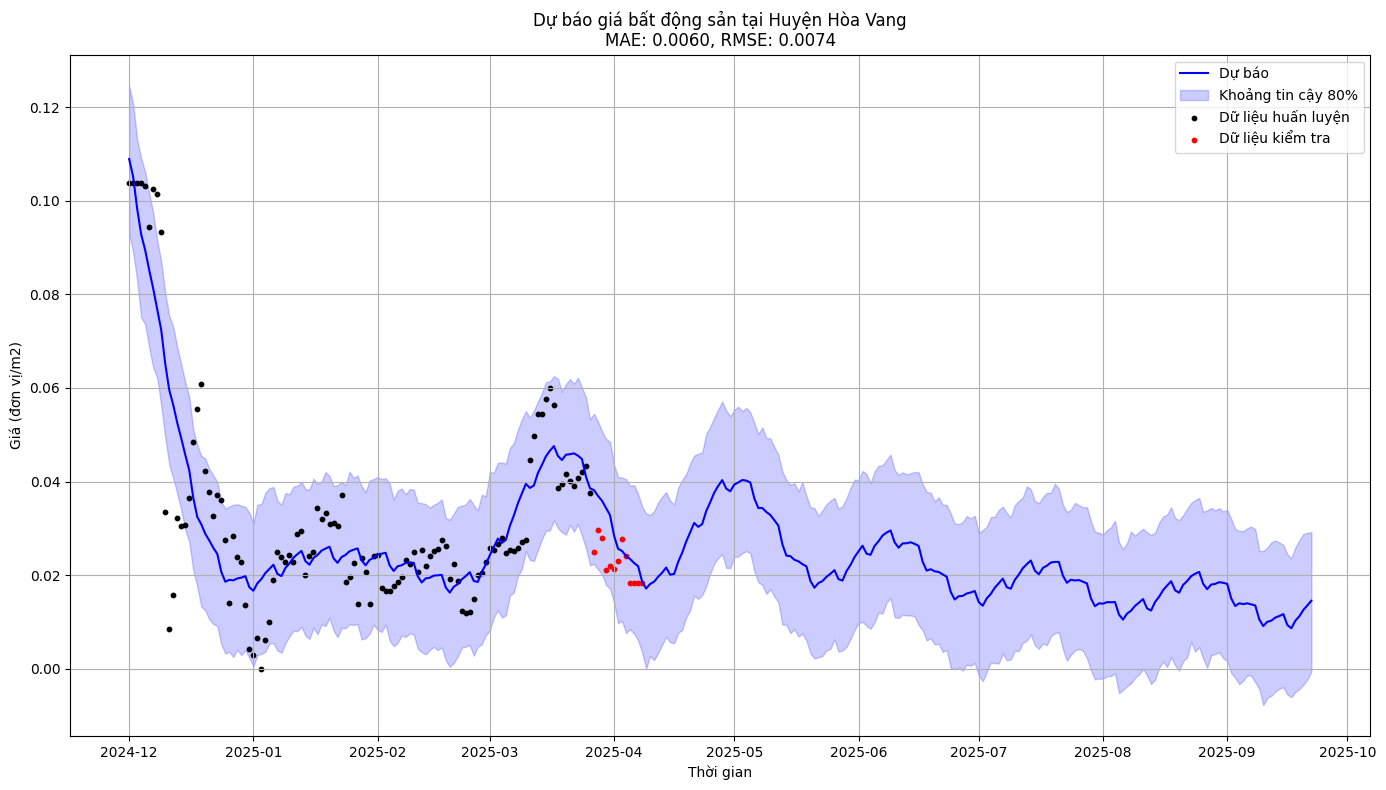

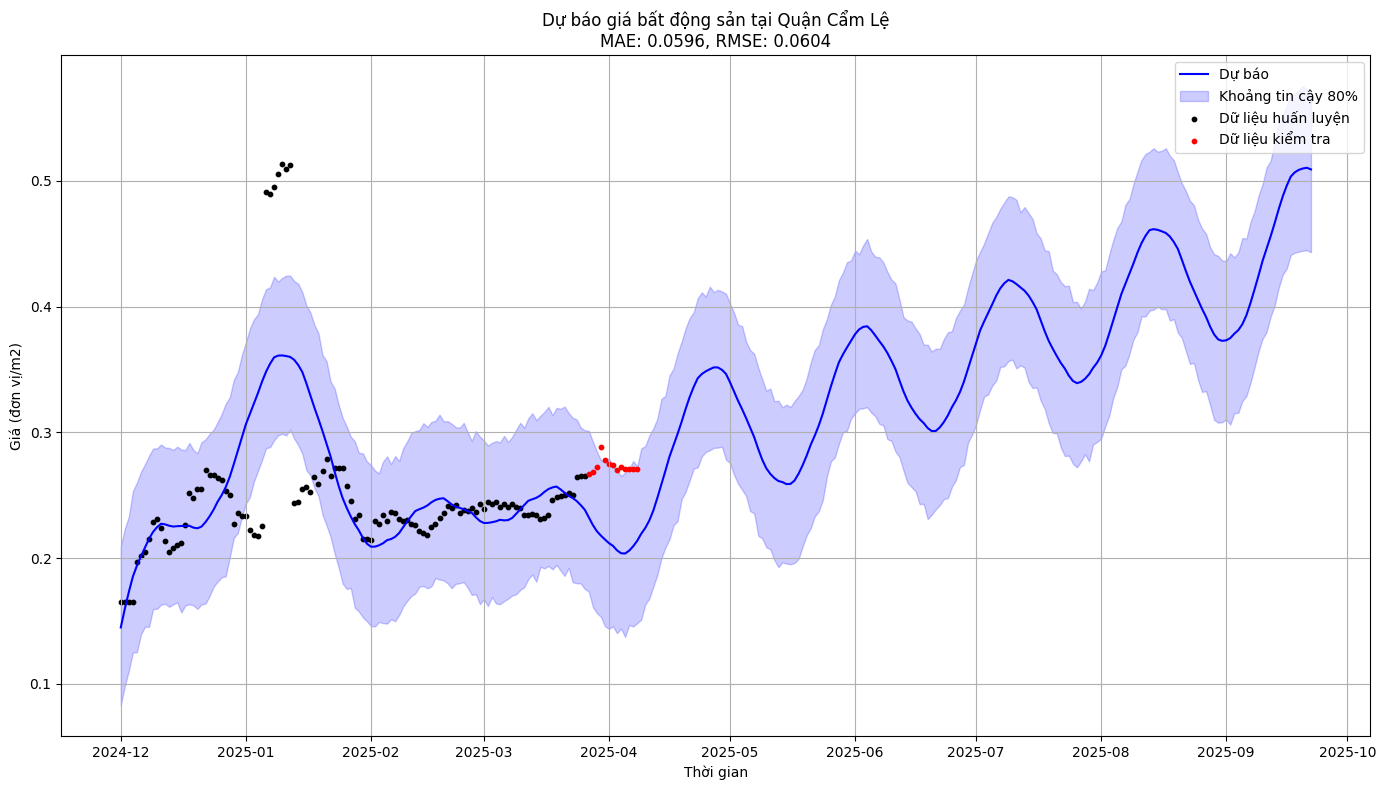

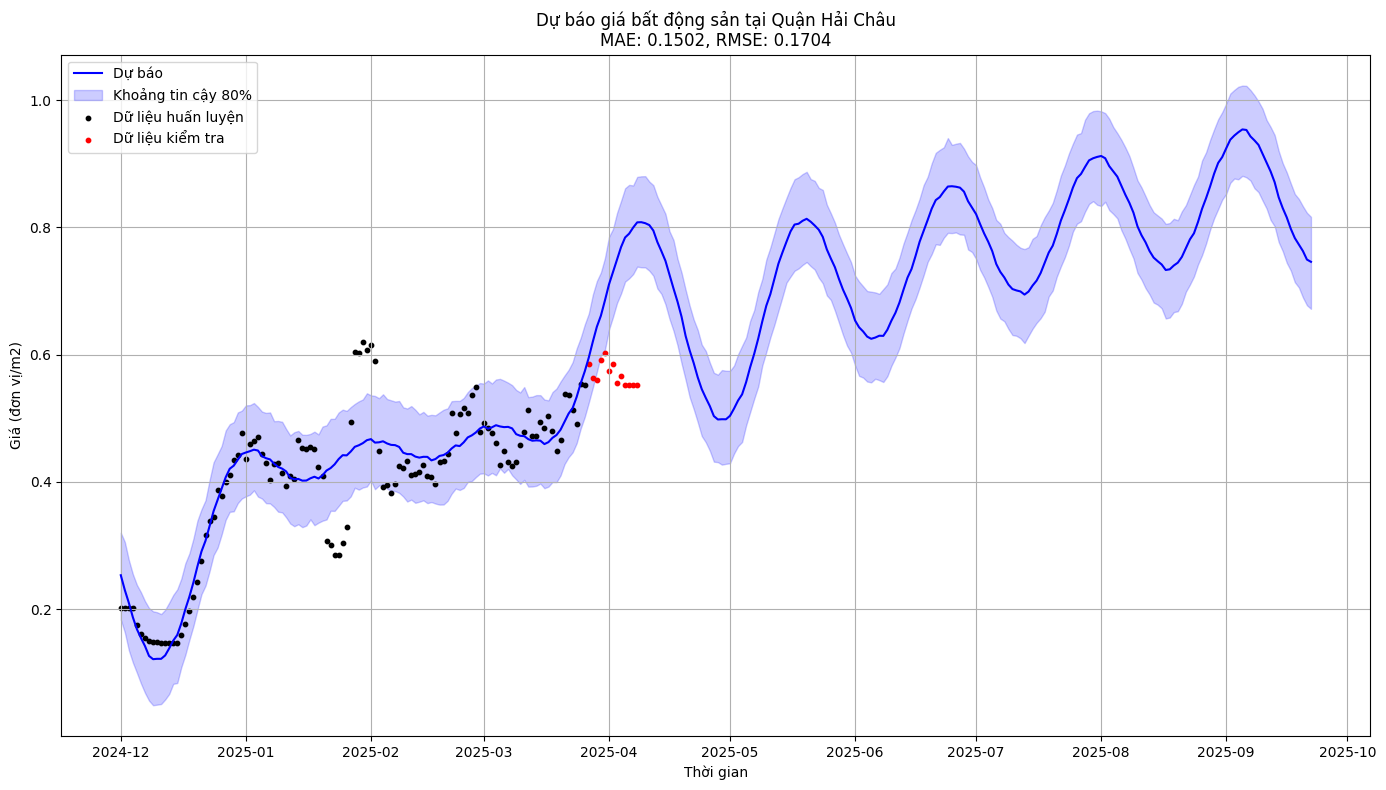

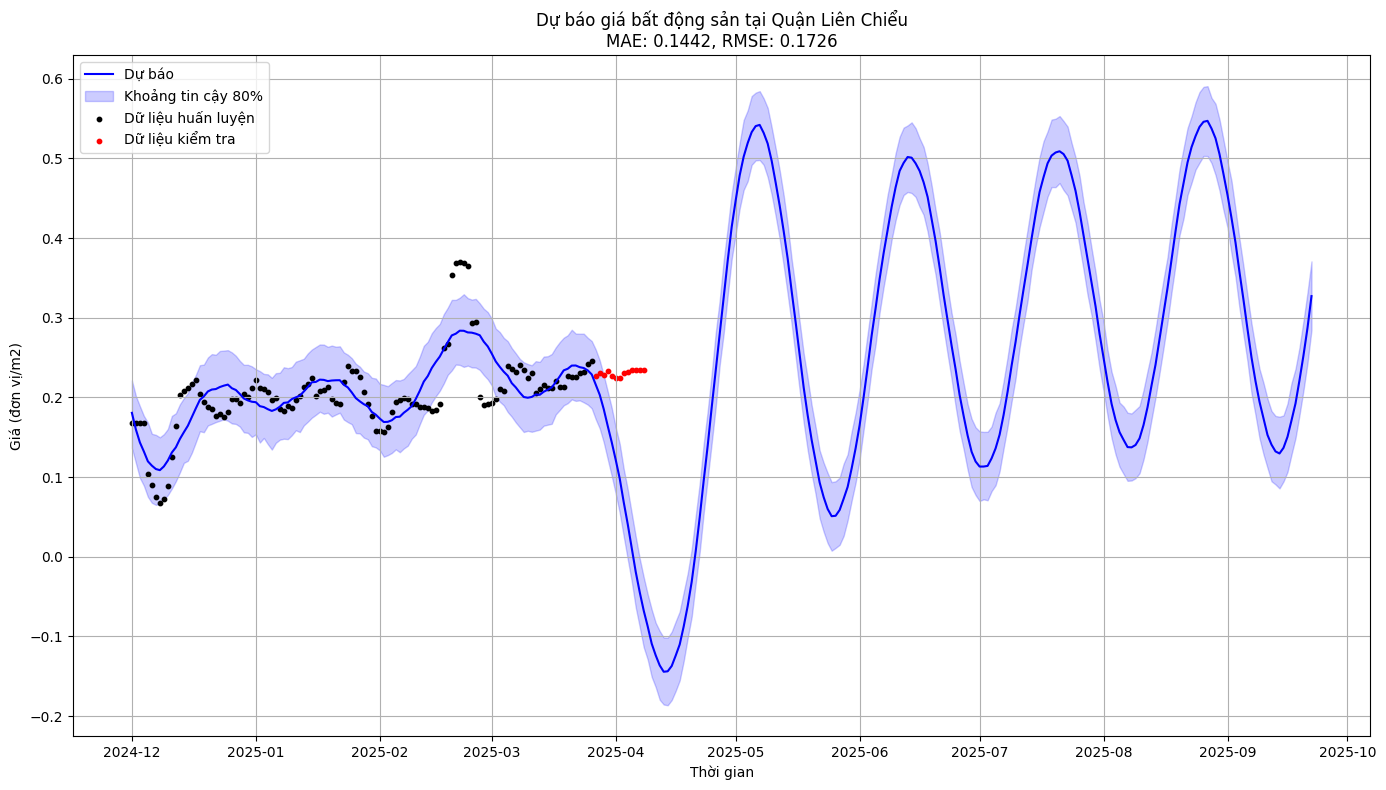

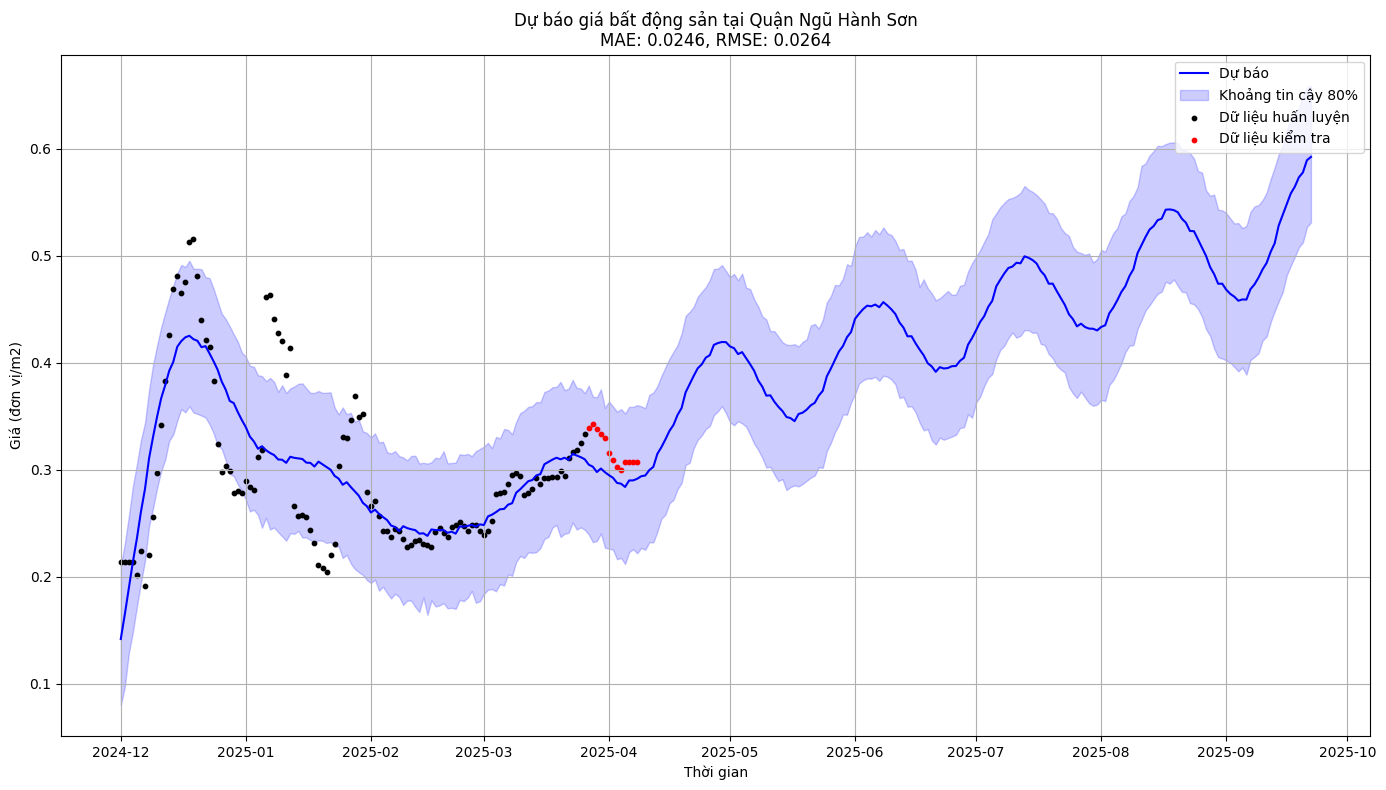

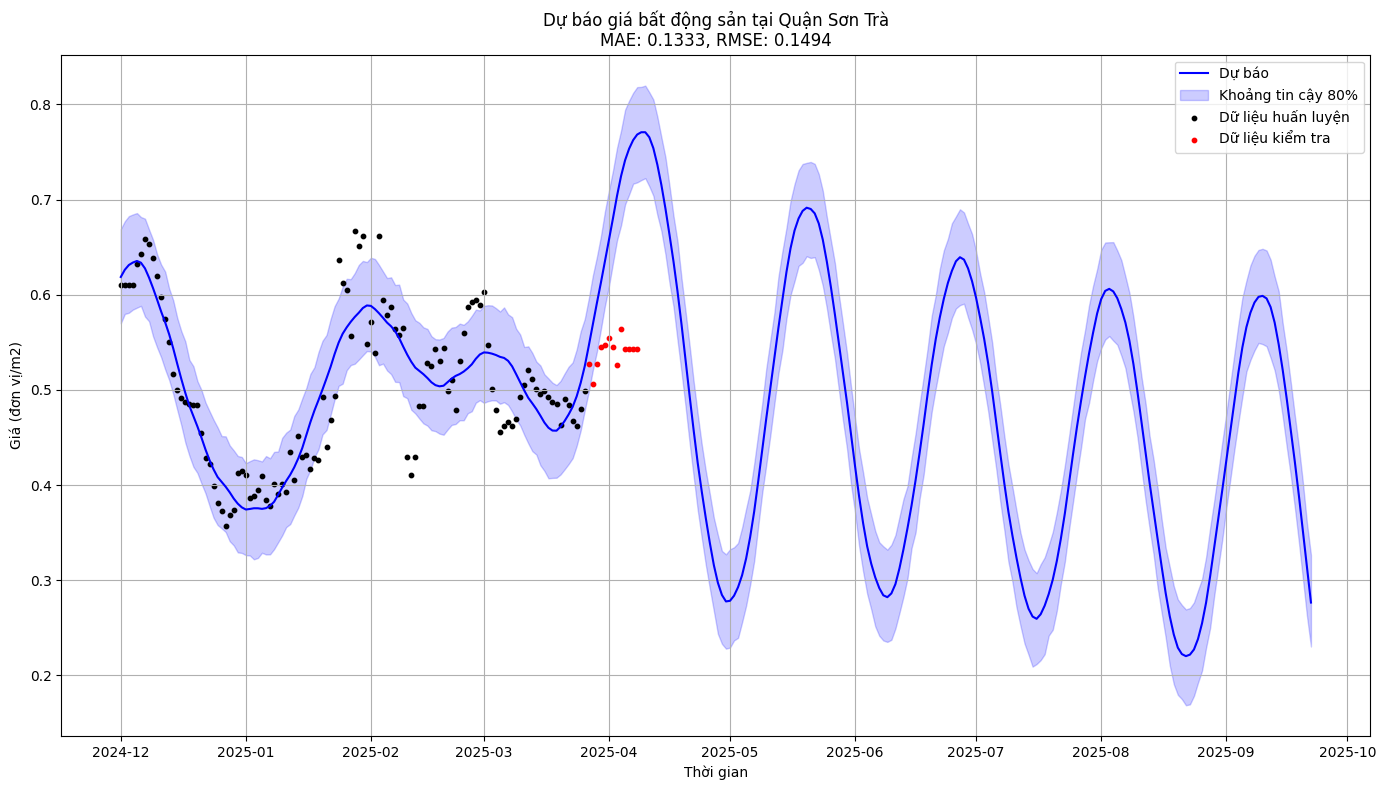

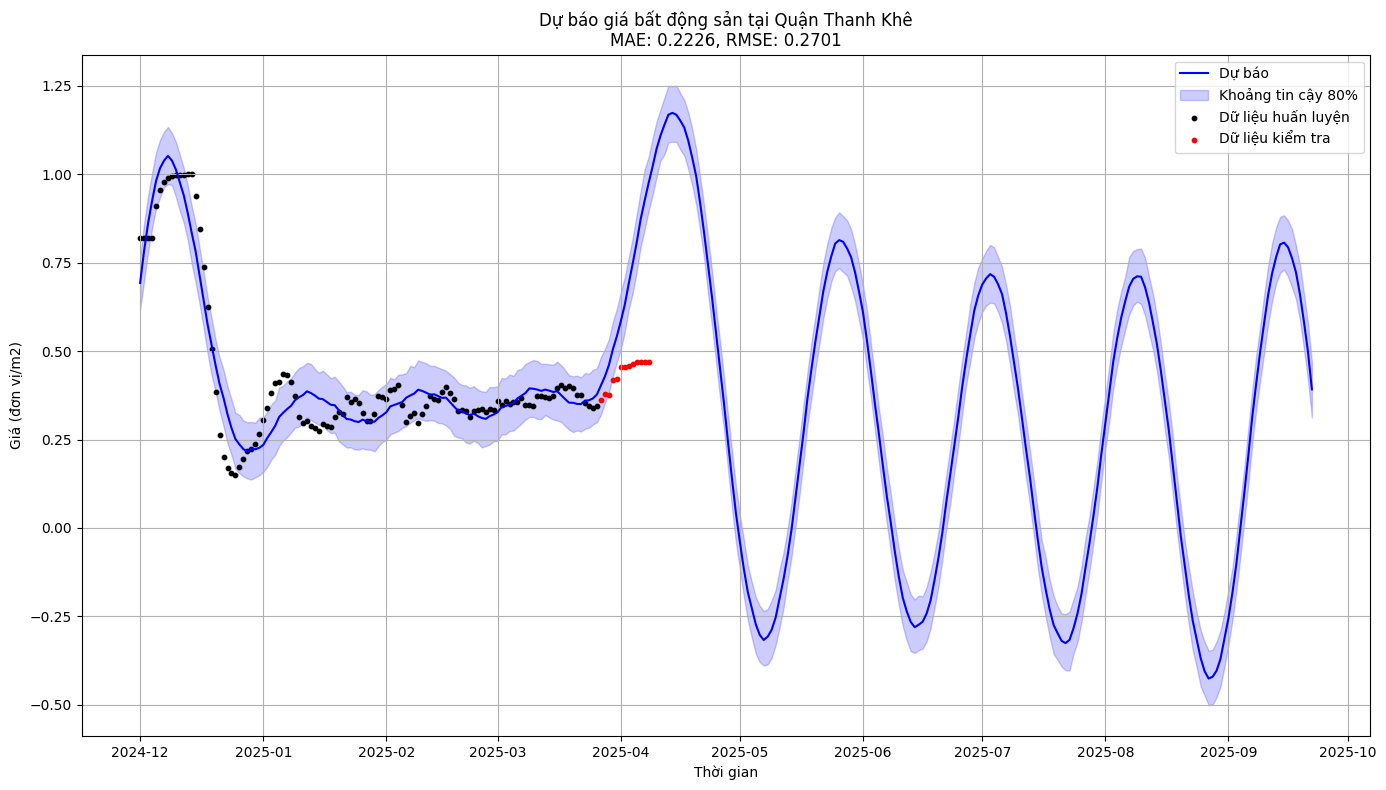

In [127]:
def plot_district_forecast(district, model, eval_result, datasets):
    """
    Vẽ biểu đồ dự báo giá cho một quận cụ thể
    
    Parameters:
    district (str): Tên quận
    model (Prophet): Mô hình đã huấn luyện
    eval_result (dict): Kết quả đánh giá
    datasets (dict): Dữ liệu train/test của quận
    """
    forecast = eval_result['forecast']
    train_data = datasets['train_prophet']
    test_data = datasets['test_prophet']
    
    # Vẽ biểu đồ
    plt.figure(figsize=(14, 8))
    
    # Vẽ đường dự báo và khoảng tin cậy
    plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Dự báo')
    plt.fill_between(
        forecast['ds'], 
        forecast['yhat_lower'], 
        forecast['yhat_upper'], 
        color='blue', 
        alpha=0.2, 
        label='Khoảng tin cậy 80%'
    )
    
    # Vẽ dữ liệu huấn luyện
    plt.scatter(train_data['ds'], train_data['y'], color='black', s=10, label='Dữ liệu huấn luyện')
    
    # Vẽ dữ liệu kiểm tra nếu có
    if not test_data.empty:
        plt.scatter(test_data['ds'], test_data['y'], color='red', s=10, label='Dữ liệu kiểm tra')
    
    # Thông tin về chỉ số đánh giá
    metrics = eval_result['test_metrics']
    metrics_text = f"MAE: {metrics['mae']:.4f}, RMSE: {metrics['rmse']:.4f}"
    
    plt.title(f'Dự báo giá bất động sản tại {district}\n{metrics_text}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá (đơn vị/m2)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    return plt

# Vẽ dự báo cho từng quận
for district in districts:
    plot_district_forecast(
        district,
        district_models[district],
        evaluation_results[district],
        district_datasets[district]
    ).show()

#### Model testing

In [128]:
def forecast_district_range(district, model, start_date, end_date):
    """
    Dự báo giá cho một quận trong một khoảng thời gian cụ thể
    
    Parameters:
    district (str): Tên quận
    model (Prophet): Mô hình đã huấn luyện
    start_date (str): Ngày bắt đầu (định dạng 'YYYY-MM-DD')
    end_date (str): Ngày kết thúc (định dạng 'YYYY-MM-DD')
    
    Returns:
    DataFrame: Kết quả dự báo trong khoảng thời gian
    """
    # Chuyển đổi sang datetime
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Tạo dataframe các ngày cần dự báo
    dates = pd.date_range(start=start, end=end)
    future = pd.DataFrame({'ds': dates})
    
    # Thêm cap và floor cho logistic growth
    if model.growth == 'logistic':
        # Lấy cap và floor từ mô hình
        cap_value = model.history['cap'].max() if 'cap' in model.history else model.history['y'].max() * 1.5
        future['cap'] = cap_value
        future['floor'] = 0
    
    # Dự báo
    forecast = model.predict(future)
    
    # Tạo dataframe kết quả đẹp hơn
    result_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(
        columns={
            'ds': 'Ngày', 
            'yhat': 'Giá dự báo', 
            'yhat_lower': 'Giá thấp nhất (80%)', 
            'yhat_upper': 'Giá cao nhất (80%)'
        }
    )
    
    return result_df

In [129]:
selected_district = districts[0]  # Thay đổi theo quận bạn muốn dự báo
start_date = '2025-05-06'         # Thay đổi theo nhu cầu
end_date = '2025-06-06'           # Thay đổi theo nhu cầu

forecast_result = forecast_district_range(
    selected_district,
    district_models[selected_district],
    start_date,
    end_date
)

print(f"Dự báo giá cho {selected_district} từ {start_date} đến {end_date}:")
forecast_result.head(10)  # Hiển thị 10 ngày đầu tiên

Dự báo giá cho Huyện Hòa Vang từ 2025-05-06 đến 2025-06-06:


,Ngày,Giá dự báo,Giá thấp nhất (80%),Giá cao nhất (80%)
0,2025-05-06,0.036401,0.020462,0.051793
1,2025-05-07,0.034322,0.018873,0.049860
2,2025-05-08,0.034337,0.019236,0.050493
3,2025-05-09,0.033480,0.015443,0.049818
4,2025-05-10,0.032849,0.016826,0.048289
5,2025-05-11,0.031734,0.015006,0.047033
6,2025-05-12,0.030575,0.013841,0.046700
7,2025-05-13,0.026597,0.011103,0.041855
8,2025-05-14,0.024162,0.009324,0.039505
9,2025-05-15,0.024044,0.008319,0.040685


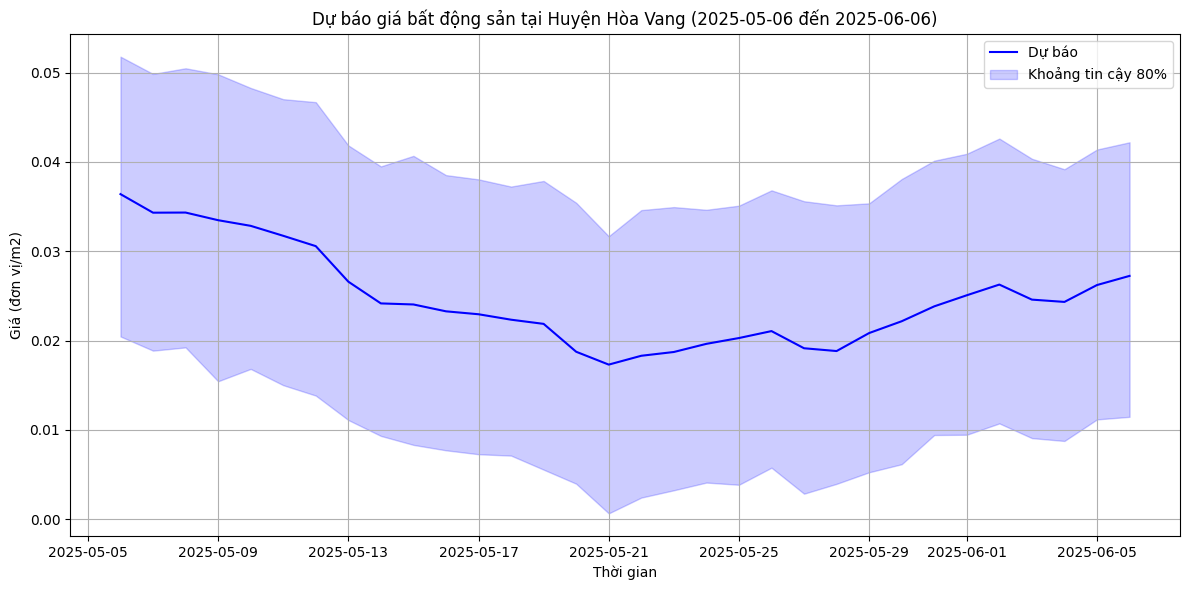

In [130]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_result['Ngày'], forecast_result['Giá dự báo'], color='blue', label='Dự báo')
plt.fill_between(
    forecast_result['Ngày'],
    forecast_result['Giá thấp nhất (80%)'],
    forecast_result['Giá cao nhất (80%)'],
    color='blue',
    alpha=0.2,
    label='Khoảng tin cậy 80%'
)

plt.title(f'Dự báo giá bất động sản tại {selected_district} ({start_date} đến {end_date})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (đơn vị/m2)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [131]:
def forecast_all_districts(models, start_date, end_date):
    """
    Dự báo giá cho tất cả các quận trong một khoảng thời gian
    
    Parameters:
    models (dict): Dictionary chứa các mô hình đã huấn luyện
    start_date (str): Ngày bắt đầu (định dạng 'YYYY-MM-DD')
    end_date (str): Ngày kết thúc (định dạng 'YYYY-MM-DD')
    
    Returns:
    dict: Kết quả dự báo cho từng quận
    """
    results = {}
    
    for district, model in models.items():
        results[district] = forecast_district_range(
            district, model, start_date, end_date
        )
    
    return results

In [132]:
all_forecasts = forecast_all_districts(district_models, start_date, end_date)

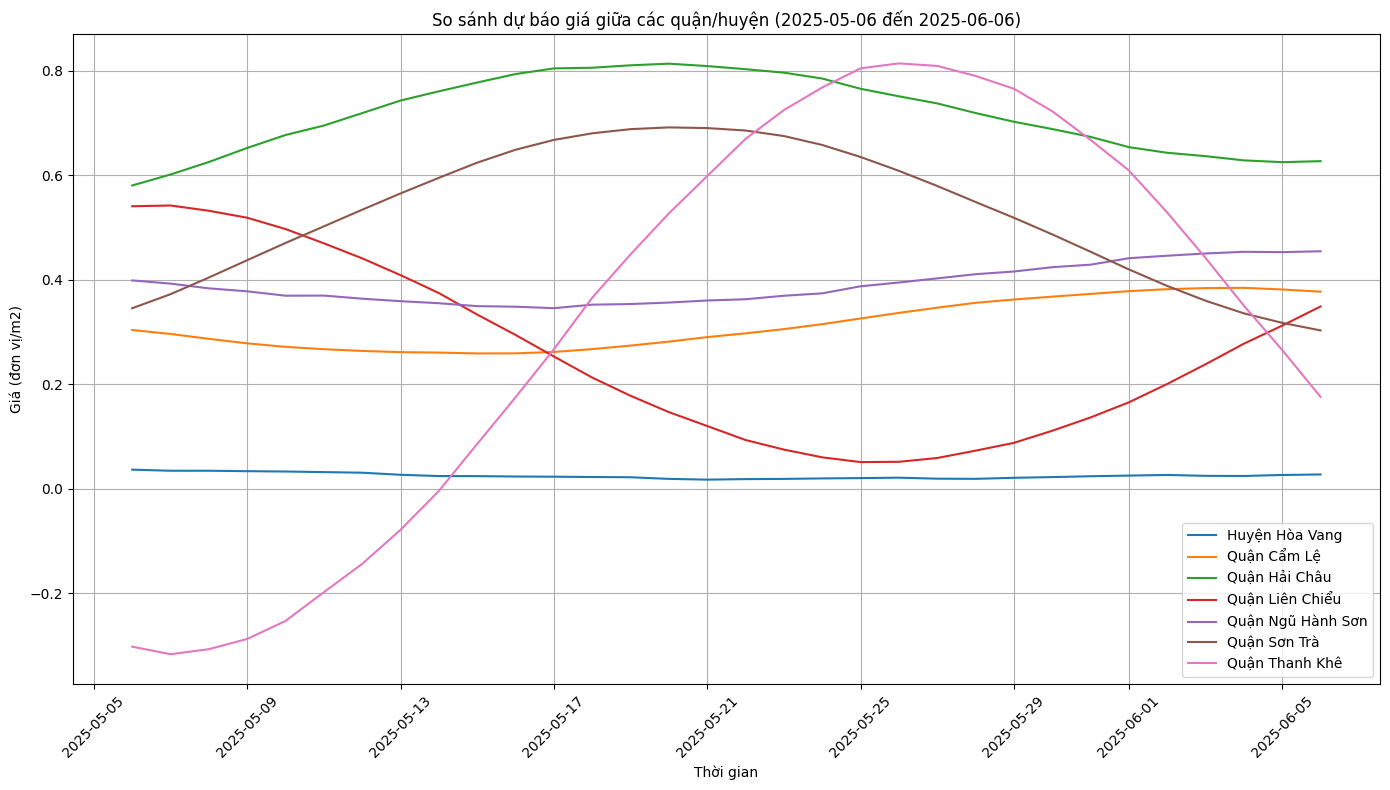

In [133]:
plt.figure(figsize=(14, 8))

for district, forecast_df in all_forecasts.items():
    plt.plot(forecast_df['Ngày'], forecast_df['Giá dự báo'], label=district)

plt.title(f'So sánh dự báo giá giữa các quận/huyện ({start_date} đến {end_date})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (đơn vị/m2)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Export model

In [134]:
filename = "district_prophet_models.pkl"

with open(filename, 'wb') as f:
    pickle.dump(district_models, f)

resource_dir = "../../Backend/src/main/resources/"
os.makedirs(resource_dir, exist_ok=True)
resource_path = os.path.join(resource_dir, filename)

with open(resource_path, 'wb') as f:
    pickle.dump(district_models, f)

print("Đã lưu mô hình Prophet thành công")

Đã lưu mô hình Prophet thành công
